In [2]:
import numpy as np
import pandas as pd
import Fourier_Power_Spectrum
import plotting_utilities
import save_utilities
import matplotlib.pyplot as plt
import random
from scipy.ndimage import gaussian_filter1d
import time 
from tqdm.notebook import tqdm 
import torch 

In [4]:
# get target data (Lilac 114, Neuron 1, epoch_1.txt)
# Column1: Current, Column2: Voltage
try:
    lilac_114_1_1 = pd.read_csv('./Data2022-50KhZ/7-7-2022/Lilac 114/Neuron 1/epoch_1.txt', delimiter='\t', header=None)
except: 
    lilac_114_1_1 = pd.read_csv('./Data2022-50KhZ/Lilac 114/Neuron 1/epoch_1.txt', delimiter='\t', header=None)
lilac_114_1_1.reset_index(inplace=True)
lilac_114_1_1.columns = ['Time', 'Current', 'Voltage']
lilac_114_1_1.head()

,Time,Current,Voltage
0,0,-4.179686,-64.490236
1,1,0.092775,-64.337648
2,2,-7.841795,-64.581788
3,3,0.092775,-64.307130
4,4,-2.958983,-64.429200


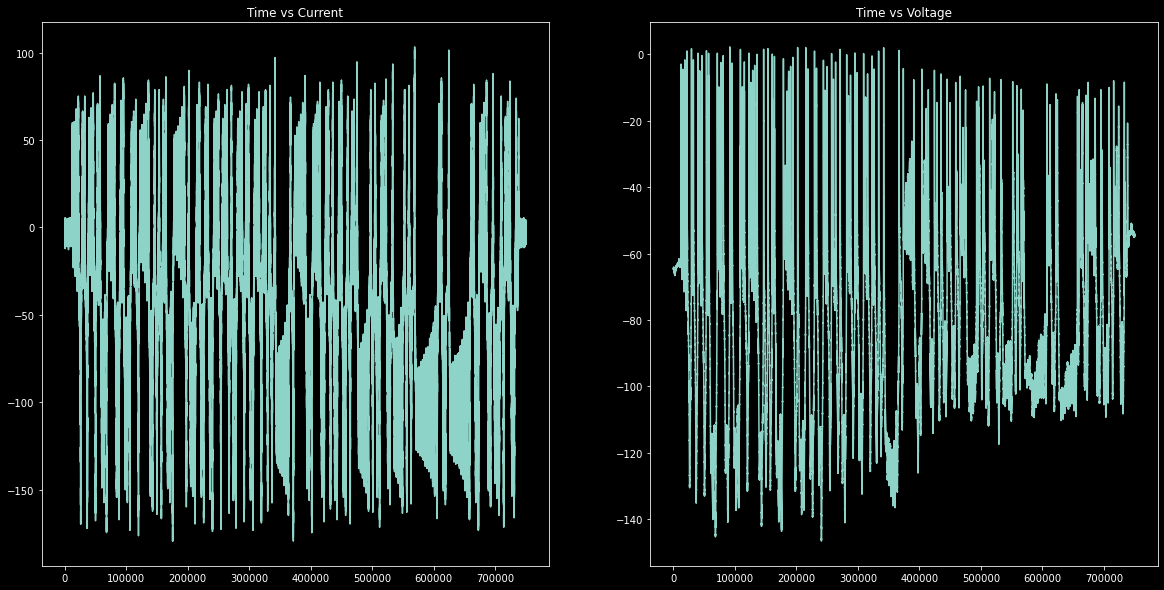

In [5]:
# plot to visualize 
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title("Time vs Current")
ax1.plot(lilac_114_1_1.Time, lilac_114_1_1.Current)
ax2.set_title("Time vs Voltage")
ax2.plot(lilac_114_1_1.Time, lilac_114_1_1.Voltage)
plt.show()

#### False Nearest Neighbor Algorithm to Determine Time Delay Vector Dimensionality 

##### Procedure
1. Define the target time delay vector (regressor) to run FNN on, and then generate time delay vectors for each time step of the voltage data: $\psi_{l}(t) = [y(k-\tau), ..., y(k-l \tau)] \text{ where } l\in[0, D]$.
2. For each points, identify the closest point in time delay space (we can search within a window, or through out all points), i.e. minimize this distance: $d = ||\psi_{l}(t_1) - \psi_{l}(t_2)||$.
3. The inequality below determines if two closest points are "true neighbors" or "false neighbors": $$\frac{|y(t)-y(j)|}{||\psi_l(t) - \psi_l (j)||_2} \leq R$$
    - If inequality is true, then the two points are true neighbors. 
    - If inequality is false, then the two points are false neighbors. 
4. Repeat step 3 for all points in the dataset, and then record the percentage of points in datasets with false nearest neighbors, giving the current time delay vector dimension. 
5. Increase the value of D until the percentage of false nearest neighbors is minimized. 

##### 1. Create time delay vectors

In [30]:
# define tau (user provided), distance ratio threshold R (user defined hyperparameter), and range of D to search over (trainable parameter)
tau = 10
R_ratio = 10 # TODO: Investigate optimal value of R; 10 is suggested by the original paper 
D_arr = np.array([1, 2, 4, 6, 8, 10, 12, 15, 18, 20]) # TODO: update d values 

# TODO: change window to random sampling data from entire dataset, or start with every 1000th data points and move down on the skip size 
# plot code are in the branch "random center robustness" - "MultiFile_FPS_Plot_and_Train_Test_RBF.py" is different in that branch
# TODO: save result as txt file; rows: D values, column: FNN ratio,  

In [27]:
# create the time delay vectors for each data points with each of the D values
original_data = lilac_114_1_1.to_numpy()
T = original_data[:, 0]
I = original_data[:, 1]
V_0 = original_data[:, 2] # voltage at 0*tau

# time the operation 
start = time.time()

# store all the array in a list
time_delay_datasets = [V_0[:-D*tau][:, None] for D in D_arr] # shape is different for each voltage value in the list

for D_index in range(len(D_arr)): 
    # print(time_delay_datasets[D_index].shape)
    # print(np.array([V_0[d*tau:-(D_arr[D_index]-d)*tau] 
    #     if -(D_arr[D_index]-d)*tau != 0 else V_0[d*tau:]
    #     for d in range(1, 1+D_arr[D_index])]).T.shape)
    # for each D we want to append to the array of data, a new dimension of voltage 
    time_delay_datasets[D_index] = np.concatenate(
                                            [time_delay_datasets[D_index], 
                                                np.array([V_0[d*tau:-(D_arr[D_index]-d)*tau] 
                                                if -(D_arr[D_index]-d)*tau != 0 else V_0[d*tau:]
                                                for d in range(1, 1+D_arr[D_index])]).T], 
                                            axis=1)
    
end = time.time()

print(f"This took {end-start}.")        

This took 0.35799717903137207.


In [28]:
# check the datasets shapes
for D_index in range(len(D_arr)): 
    print(f"For D={D_arr[D_index]}, the shape of the dataset is {time_delay_datasets[D_index].shape}")

For D=1, the shape of the dataset is (749990, 2)
For D=2, the shape of the dataset is (749980, 3)
For D=4, the shape of the dataset is (749960, 5)
For D=6, the shape of the dataset is (749940, 7)
For D=8, the shape of the dataset is (749920, 9)
For D=10, the shape of the dataset is (749900, 11)
For D=12, the shape of the dataset is (749880, 13)
For D=15, the shape of the dataset is (749850, 16)
For D=18, the shape of the dataset is (749820, 19)
For D=20, the shape of the dataset is (749800, 21)


In [29]:
# check the data 
"""
Every second element should match up with the first element of the Dth row down the line, i.e. array[0, 1] == array[D, 1] 
"""
time_delay_datasets[0][:10] 


array([[-64.49023555, -64.30713008],
       [-64.33764765, -64.2766125 ],
       [-64.58178828, -64.58178828],
       [-64.30713008, -64.30713008],
       [-64.42920039, -64.55127071],
       [-64.52075313, -64.33764765],
       [-64.2766125 , -64.67334102],
       [-64.36816523, -64.52075313],
       [-64.24609492, -64.24609492],
       [-64.64282344, -64.58178828]])

##### 2. Calculate distance between points, and for each point, find its closest point

In [33]:
# change the data from array to tensor for faster calculation 
torch.device('cuda')

time_delay_datasets = [torch.tensor(arr) for arr in time_delay_datasets]

In [40]:
time_delay_datasets[0][0]

tensor([-64.4902, -64.3071], dtype=torch.float64)

In [38]:
# def calc_min_distance(data_point, array_points): 
#     """Given a data point and its corresponding dataset, return the distance between that point to all other points in the array points"""
#     distance = np.linalg.norm(array_points - data_point, axis=1)
#     result = np.array([data_point, array_points[np.argmin(distance)]])
#     return result
# calc_min_distance(time_delay_datasets[0][0], time_delay_datasets[0])

C:\Users\xueze\AppData\Local\Temp\ipykernel_4880\4096637510.py:4: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = np.array([data_point, array_points[np.argmin(distance)]])
C:\Users\xueze\AppData\Local\Temp\ipykernel_4880\4096637510.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.array([data_point, array_points[np.argmin(distance)]])


array([tensor([-64.4902, -64.3071], dtype=torch.float64),
       tensor([-64.4902, -64.3071], dtype=torch.float64)], dtype=object)

In [43]:
# def calc_min_distance(data_point, array_points): 
#     """Given a data point and its corresponding dataset, return the distance between that point to all other points in the array points"""
#     distance = torch.norm(array_points - data_point, dim=1)
#     result = torch.cat([data_point, array_points[torch.argmin(distance)]])
#     return result
# # calc_min_distance(time_delay_datasets[0][0], time_delay_datasets[0])

The process of find the nearest point for all available points in the dataset takes 2 hours (projected) for each dataset, lets try this with a smaller window=200

In [ ]:
# calculate the min distance result (test) - window=200 will run for 20 mins
test_data = time_delay_datasets[0]

def generate_min_dist_datapoints(data, window=1000): 
    result_data, result_index = [], []
    for i in tqdm(range(len(data))): 

        # create a window of data point to search over 
        # save the starting index and the ending index of our window as reference
        start_index, end_index = max(i-window, 0), min(len(data), i+window)

        # exclude the target point from the window
        search_window = torch.cat([
            data[start_index:i], 
            data[i+1:end_index]
        ]) 

        # run the distance calculation and find the closest point and their indices
        distance = torch.norm(search_window - data[i], dim=1)
        min_distance_index = torch.argmin(distance) # index of minimum distance point inside the window of datapoints 
        min_distance_pair_data = [data[i].data, search_window[min_distance_index].data]

        # find the real index in respect to the entire dataset 
        real_min_distance_index = start_index + min_distance_index + 1 if start_index + min_distance_index >= i else start_index + min_distance_index
        min_distance_pair_index = [i, real_min_distance_index.data]

        # save the closest point's index
        # this is the k and j: index of the first and second data points 
        result_data.append(min_distance_pair_data)
        result_index.append(min_distance_pair_index)

        # early stopping for testing purposes 
        # if i > 100: 
        #     break
    
    # convert the list to numpy array 
    result_data = np.array(result_data)
    result_index = np.array(result_index)

    
    print("Saving results...")
    np.save(f'min_datapairs_D={test_data.shape[1]}_window={window}_datapoints', result_data)
    np.save(f'min_datapairs_D={test_data.shape[1]}_window={window}_location', result_index)
    print("Results saved.")
    return result_data, result_index

test_data, test_index = generate_min_dist_datapoints(test_data)

##### 3. Count the number of False Nearest Neighbors and True Nearest Neighbors in the current setup 

In [8]:
# load from npy file 
D_1 = np.load(".\FNN\min_datapairs_D=2_window=1000_location.npy")
D_1.astype(np.int)

C:\Users\xueze\AppData\Local\Temp\ipykernel_6308\2741463027.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  D_1.astype(np.int)


array([[     0,    564],
       [     1,     22],
       [     2,    514],
       ...,
       [749977, 749839],
       [749978, 749920],
       [749979, 749295]])

In [ ]:
def count_fnn(dataset, threshold_R=R):
    """
    Parameters: 
    dataset: A dataset should contain all the points and their closest point in pairs; example [(point_vec1, point_vec2)_1, (point_vec1, point_vec2)_2, ...]
    threshold_R: This threshold determines ratio needed between the actual distance and the time delay distance to be recognized as a true nearest neighbor

    Return: 
    A floating point number indicating the number of false nearest neighbors in the dataset. 
    """
    tnn, fnn = 0, 0
    for vec1, vec2 in dataset: 
        true1, true2 = vec1[0], vec2[0]# the first value of each array are the true voltage value 
        time_dist = np.linalg.norm(vec1 - vec2, ord=2) # time delay distance between the two points 
        actual_dist = np.abs(true1 - true2) # actual distance 
        dist_ratio = actual_dist / time_dist 

        if dist_ratio <= threshold_R: # determine falsehood 
            fnn += 1
        else: 
            tnn += 1
    return fnn / (fnn+tnn)
    

In [ ]:
# test the function on the first dataset
fnn_ratio = count_fnn(test_result)

##### 4. Repeat the search for all D values

In [ ]:
# iterate through the D array and run the ratio calculation algorithm 
from collections import defaultdict
result = defaultdict(float)
for d_index in range(len(D_arr)): 
    dataset = time_delay_datasets[d_index] # get the time delay vectors 
    min_dist_vector_pairs = generate_min_dist_datapoints(dataset) # generate data pairs 
    result[D_arr[d_index]] = count_fnn(min_dist_vector_pairs)
    

In [ ]:
# visualize the result 
fig = plt.figure(figsize=(10,10))
plt.scatter(list(result.keys()), list(result.values()), c='green')
plt.show()